<div style="text-align: left; font-size: 2.5em; font-weight: bold; margin-bottom: 1em;">Misunderstandings in animal social network analysis: interaction- and association-based net-
works are comparable</div>

The goal of this notebook is to demonstrate how conflating interactions and associations can alter research outcomes.
We develop a simulation with three components: (i) an interaction network generation process that determines the *potential* interactions we might measure, (ii) a group formation process that dictates which configurations of animals can be observed on any given day, and (iii) an imperfect measurement process that generates interaction/association data based on potential interactions and group memberships.


* Author: Jean-Gabriel Young <jyoung22@uvm.edu> + Ben Kawam <bkawam@dpz.eu>
* Licenses:
  * Code: MIT
  * Content: CC BY 4.0
* Originally written: March 2025
* Last modified: June 2025

In [38]:
# generic python libraries
from typing import Callable
import itertools as it
from collections import Counter

# scientific libraries
import networkx as nx
import numpy as np
import random
from scipy.spatial.distance import cdist
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, to_rgba

# fix seeds
np.random.seed(42)
random.seed(42)

# Simulated data generation

In this first part of the notebook, we define the data generation process.

It comprises three components: 
1. A generative model for the network of preferences amongst animals;
2. A group formation process;
3. A measurement process.

The following subsections go through each step of the process.

## Network model

To obtain realistic networks of preferences, we use a model with a latent trait space.
In this model, animals occupy random positions in a social trait space, with proximity between animals indicating stronger relational tendencies.
This latent trait space is modeled as the euclidean space in $d$ dimension, $\mathbb{R}^d$.
We can think of positions in this space as defining a unique combinations of traits as it relates to the tendency to create connections.

Our model includes distinct social *niches*, meant to capture groups of animals with similar traits that might cluster in social groups as a result.
We create the niches by sampling centroids $\mu_r$ for each niche $r=1,2,...,k$ where $k$ is the number of niches.
We then randomly assigned animals to niches and sampled each animal's trait space location from a Gaussian distribution centered at its niche's $\mu_r$.
Finally, a network of "preferences"---potential interactions---is generated randomly.
The positions of animals in the trait space is used by increasing the likelihood of a relationship as the distance between animals in trait space decreases.
We employ an exponentially decreasing connection probability, $p_{ij}=e^{-\beta \Delta_{ij}}$, where $\Delta_{ij}$ represents the distance between animals $i$ and $j$ in trait space---though other functions could easily be used.
To ensure that the resulting network makes sense from a social point of view, we further conditioned the generating process on obtaining a connected graph.

The functions below define this generative process.

In [19]:
def ensure_connected(func):
    """Decorator to ensure that the generated network is connected."""
    def wrapper(*args, **kwargs):
        while True:
            output = func(*args, **kwargs)
            if isinstance(output, nx.Graph):
                g = output
            else:
                g = output[0]
            if nx.is_connected(g):
                return output
    return wrapper

@ensure_connected
def network_generation_model(num_nodes: int,
                              k: int,
                              centroid_generator: Callable[[], np.ndarray],
                              position_generator: Callable[[np.ndarray], np.ndarray],
                              connection_function: Callable[[np.ndarray], float]) -> nx.Graph:
    """
    Generate network by placing nodes in a latent space and connecting them based on their distance.
    
    Parameters
    ----------
    num_nodes : int
        Number of nodes in the network.
    k : int
        Number of groups.
    centroid_generator : Callable
        Function that generates the centroids of the groups.
    position_generator : Callable
        Function that generates the positions of a node given the centroids.
    connection_function : Callable
        Function that determines the probability of connection between two nodes.
    """
    centroids = np.array([centroid_generator() for _ in range(k)])
    g = nx.Graph()
    pos = dict()
    for i in range(num_nodes):
        pos[i] = position_generator(centroids)
        g.add_node(i)
    for i, j in it.combinations(range(num_nodes), 2):
        if np.random.rand() < connection_function(pos[i], pos[j]):
            g.add_edge(i, j)
    return g, centroids, pos

This generic function takes 3 methods as input; they specify the 
1. distribution of centroids;
2. distribution of positions given the centroids;
3. connection probability as a function of the distance.

The standard choice used in the paper are below.

In [20]:
def gaussian_centroids(n_dim: int, var: float = 1.0) -> np.ndarray:
    """
    Generate random centroids for the groups.
    
    Drawn from a multivariate normal distribution with zero mean and identity covariance.

    Parameters
    ----------
    n_dim : int
        Number of dimensions of the latent space.
    var : float
        Variance of the distribution.

    Returns
    -------
    np.ndarray
        Array of centroids.
    """
    return np.random.multivariate_normal(np.zeros(n_dim), np.eye(n_dim) * var)

def gaussian_position(centroids: np.ndarray, var: float = 1.0) -> np.ndarray:
    """
    Generate random position for a node.
    
    Drawn from a multivariate normal distribution with mean equal to the centroid and identity covariance.
    Picks a centroid uniformly at random.

    Parameters
    ----------
    centroids : np.ndarray
        Array of centroids.
    var : float
        Variance of the distribution.

    Returns
    -------
    np.ndarray
        Position as an array.
    """
    centroid = centroids[np.random.randint(centroids.shape[0])]
    n_dim = centroids.shape[1]
    return centroid + np.random.multivariate_normal(np.zeros(n_dim), np.eye(n_dim) * var)

def exponential_decay_connection(pos_i: np.ndarray, pos_j: np.ndarray, beta: float = 1.0) -> float:
    """
    Connection function based on the distance between nodes.

    Parameters
    ----------
    pos_i, pos_j : np.ndarray
        Position of the two nodes.
    beta : float
        Decay parameter. Higher values lead to faster decay.

    Returns
    -------
    float
        Probability of connection
    """
    return np.exp(-np.linalg.norm(beta * (pos_i - pos_j)))

To demonstrate these functions in action, let's generate a network in a trait space of dimension $d=2$, with $k=3$ niches.


In [21]:
# Example use
num_nodes = 100
k = 3
num_dims = 2
beta = 2.0              # speed at which the connection probability decays with distance
var_centroids = 8.0     # variance of the centroids --- how far apart they tend to be
var_positions = 0.5     # variance of the positions --- how far apart nodes in the same group tend to be


g, centroids, pos = network_generation_model(
    num_nodes=num_nodes,
    k=k,
    centroid_generator=lambda: gaussian_centroids(num_dims, var_centroids),
    position_generator=lambda x: gaussian_position(x, var_positions),
    connection_function=lambda x, y: exponential_decay_connection(x, y, beta)
)

We'll now visualize the resulting network.

The following function is a simple helper to color nodes based on their distance to the nearest centroid.

In [22]:
def color_nodes_by_centroid_distance(G, pos, centroids, cmap_name='Set3'):
    """
    Color nodes based on their distances to centroids.
    
    Parameters:
    -----------
    G : networkx.Graph
        The network graph
    pos : dict
        Dictionary of node positions
    centroids : numpy.ndarray
        Array of centroid positions
    cmap_name : str
        Name of the colormap to use
    
    Returns:
    --------
    node_colors : list
        List of colors for each node
    """
    pos_array = np.array([pos[i] for i in G.nodes()])
    distances = cdist(pos_array, centroids)
    inv_distances = 1 / (distances + 1e-10)
    weights = inv_distances / inv_distances.sum(axis=1, keepdims=True)
    cmap = plt.get_cmap(cmap_name, centroids.shape[0])
    centroid_colors = [cmap(i) for i in range(centroids.shape[0])]
    node_colors = []
    for node_idx, node in enumerate(G.nodes()):
        blended_color = np.zeros(4)
        for centroid_idx in range(centroids.shape[0]):
            weight = weights[node_idx, centroid_idx]
            centroid_color = np.array(centroid_colors[centroid_idx])
            blended_color += weight * centroid_color
        blended_color = np.clip(blended_color, 0, 1)
            
        node_colors.append(blended_color)
    
    return node_colors

And now we visualize the outcome, marking centroids with stars markers.

(Note: These centroids are *not* animals, just a location!)

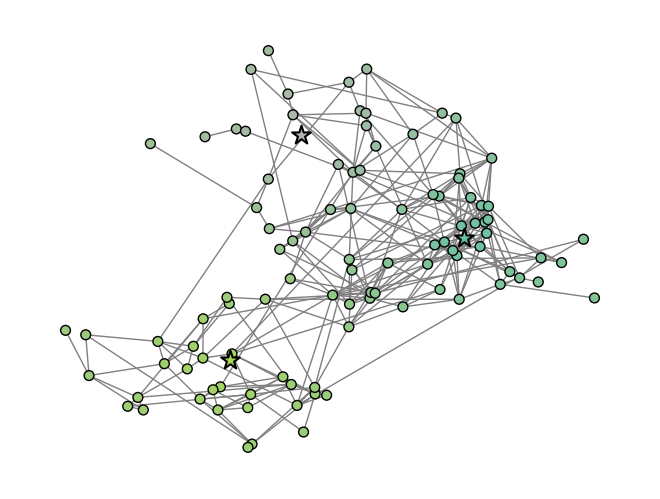

In [23]:
# Visualize
node_colors = color_nodes_by_centroid_distance(g, pos, centroids, "Set2")
nx.draw(g, pos=pos, node_size=50, edge_color='gray', edgecolors='black', node_color=node_colors)
centroid_colors = cm.Set2(np.linspace(0, 1, k))
for i, centroid in enumerate(centroids):
    plt.scatter(centroid[0], centroid[1], c=[centroid_colors[i]], s=200, 
                marker='*', edgecolors='black', linewidths=1.5, zorder=10)

## Group formation model

We now move to the group formation process.

This part of the data simulation is meant to capture the idea that we might observe different configurations of animals on any given day.
Groups should be shaped by interactions, but the process should capture that fact that unrelated animals can be found together on any given day, due to social dynamics.

We implement this idea with an abstract model that roughly:
1. First places animals in a *physical space*, in close proximity to their interaction partners.
2. Cluster the animals based on their position.


To place animals in physical space, we simulate a repulsion-attraction dynamics where potential interactions pull animals together while disconnected pairs are pushed apart.
This can be done using the standard Fruchterman-Reingold algorithm implemented in `networkx`.
We then create groups of animals based on physical proximity by applying the affinity propagation algorithm, implemented in `sklearn`.

The following function implements both steps at once.

In [24]:
def group_formation_model(g, noise: float | None = None) -> np.ndarray:
    """
    Return groups of nodes on a given measurement day.

    In this model, the groups are determined by the positions of the nodes as
    determined by an attraction/repulsion model, followed by clustering.
    
    Parameters
    ----------
    g : nx.Graph
        The network graph
    noise : float
        Noise parameter for the spring layout. If None, use default.
        Higher value lead to more random groups.

    Returns
    -------
    np.ndarray
        Group labels.
    """
    # get random positions based on a attraction/repulsion model
    if noise is None:
        pos = nx.spring_layout(g)   # this is the Fruchterman-Reingold algorithm
    else:
        pos = nx.spring_layout(g, noise)

    
    # cluster with affinity propagation
    distances = metrics.pairwise_distances(np.array([pos[i] for i in g.nodes()]))
    return AffinityPropagation(affinity='precomputed').fit(distances).labels_

We can now apply this second step to the graph `g` generated in the first step.

We'll now color nodes by groups instead of by proximity to a centroid.

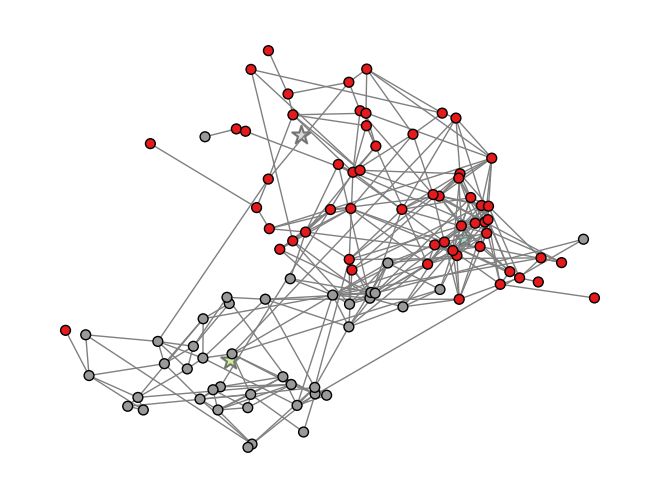

In [25]:
# Example use
noise = 0.1 # Controls the amount of noise in the groups.
            # Higher values lead to more noise.
            # Set to None for defaults.
labels = group_formation_model(g, noise)

# Visualize
nx.draw(g, pos, node_size=50, edge_color='gray', edgecolors='black', node_color=[labels[i] for i in g.nodes], cmap='Set1')
for i, centroid in enumerate(centroids):
    plt.scatter(centroid[0], centroid[1], c=[centroid_colors[i]], s=200,  alpha=0.5,
                marker='*', edgecolors='black', linewidths=1.5, zorder=-10)

## Measurement models

Finally, we simulate the measurement process with association and interaction methods across multiple days of data collection.

**Association measurements:** To generate association measurements, we assume that pairs of animals found in the same group were likely connected.
This produces a matrix of connection probabilities $\bm{W}_A$, where each $w_{ij}$ represents the proportion of days animals $i$ and $j$ were observed together.


**Interaction measurements:** To generate interaction measurements, we translate the network of potential interactions into connection probabilities $\bm{W}_I$, but add two processes that capture experimental conditions. First, we only record ties between animals that were associating during measurement. Second, we allow for false positive and false negative measurements (each occurring at a fixed rate per pair of individuals per day).

Here is what the **association** measurement process looks like, given a network and group:

In [26]:
def measure_association_network(groups: list[set[int]]) -> list[nx.Graph]:
    """
    Construct the association network from repeated grouping of a latent network.

    Parameters
    ----------
    groups : list
        List of sets of nodes in each group, for each measurement.

    Returns
    -------
    list[nx.Graph]
        Association networks.
    """
    num_measurements = len(groups)

    measurements = []

    for t in range(num_measurements):
        measured_graph = nx.Graph()
        for group in groups[t]:
            for i, j in it.combinations(group, 2):
                if measured_graph.has_edge(i, j):
                    measured_graph[i][j]['weight'] += 1
                else:
                    measured_graph.add_edge(i, j, weight=1)
        measurements.append(measured_graph)
    return measurements

def convert_labels_to_groups(labels: np.ndarray) -> list[set[int]]:
    """
    Helper function to convert labels to groups.

    Parameters
    ----------
    labels : np.ndarray
        Array of labels.

    Returns
    -------
    list[set[int]]
        List of sets of nodes in each group.
    """
    groups = []
    for label in np.unique(labels):
        groups.append(set(int(i) for i in np.where(labels == label)[0]))
    return groups

For example, with a single set of measurements:

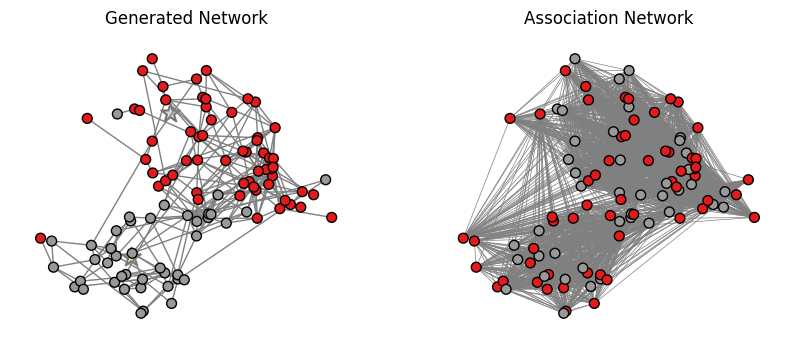

In [27]:
groups = convert_labels_to_groups(labels)
measured_graph = measure_association_network([groups])[0]


# Visualize
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Generated Network")
plt.axis('off')
nx.draw(g, pos, node_size=50, edge_color='gray', edgecolors='black', node_color=[labels[i] for i in g.nodes], cmap='Set1')
for i, centroid in enumerate(centroids):
    plt.scatter(centroid[0], centroid[1], c=[centroid_colors[i]], s=200,  alpha=0.5,
                marker='*', edgecolors='black', linewidths=1.5, zorder=-10)

plt.subplot(122)
plt.title("Association Network")
nx.draw(
    measured_graph,
    pos,
    node_size=50,
    edge_color='gray',
    edgecolors='black',
    node_color=[labels[i] for i in g.nodes],
    cmap='Set1',
    width=0.5
)

And here is what the **interaction** measurement process looks like, given a network and group:

In [28]:
def measure_interaction_network(
    groups: list[set[int]],
    g: nx.Graph,
    true_positive: float = 0.9,
    false_positive: float = 0.01
) -> list[nx.Graph]:
    """
    Construct the interaction network from repeated grouping of a latent network.

    Parameters
    ----------
    groups : list
        List of sets of nodes in each group, for each measurement.
    g : nx.Graph
        The latent network from which the groups were taken.
    true_positive : float
        Probability of a true positive connection.
    false_positive : float
        Probability of a false positive connection.

    Returns
    -------
    list[nx.Graph]
        Interaction networks.
    """
    num_measurements = len(groups)
    measurements = []

    for t in range(num_measurements):
        measured_graph = nx.Graph()
        measured_graph.add_nodes_from(g.nodes())
        for group in groups[t]:
            for i, j in it.combinations(group, 2):
                if g.has_edge(i, j):
                    if np.random.rand() < true_positive:
                        measured_graph.add_edge(i, j)
                else:
                    if np.random.rand() < false_positive:
                        measured_graph.add_edge(i, j)
        measurements.append(measured_graph)

    return measurements

For a single observation period, we get:

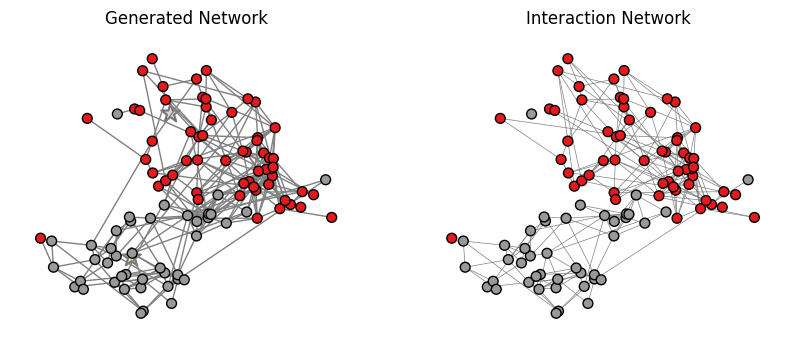

In [29]:
groups = convert_labels_to_groups(labels)
measured_graph = measure_interaction_network([groups], g)[0]


# Visualize
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Generated Network")
plt.axis('off')
nx.draw(g, pos, node_size=50, edge_color='gray', edgecolors='black', node_color=[labels[i] for i in g.nodes], cmap='Set1')
for i, centroid in enumerate(centroids):
    plt.scatter(centroid[0], centroid[1], c=[centroid_colors[i]], s=200,  alpha=0.5,
                marker='*', edgecolors='black', linewidths=1.5, zorder=-10)

plt.subplot(122)
plt.title("Interaction Network")
nx.draw(
    measured_graph,
    pos,
    node_size=50,
    edge_color='gray',
    edgecolors='black',
    node_color=[labels[i] for i in g.nodes],
    cmap='Set1',
    width=0.5
)

# Complete simulation

Putting all of the step above together, we get something like this:

In [30]:
# Step 1: Generate a network with latent positions and connections based on distance
num_nodes = 100
k = 3
num_dims = 2
beta = 2.0
var_centroids = 8.0
var_positions = 0.5

g, centroids, pos = network_generation_model(
    num_nodes=num_nodes,
    k=k,
    centroid_generator=lambda: gaussian_centroids(num_dims, var_centroids),
    position_generator=lambda x: gaussian_position(x, var_positions),
    connection_function=lambda x, y: exponential_decay_connection(x, y, beta)
)

# Step 2: Generate groups based on the positions of the nodes
num_measurements = 7
noise = 0.1
labels = [group_formation_model(g, noise) for _ in range(num_measurements)]

# Step 3: Measure the association network from the groups
groups = [convert_labels_to_groups(l) for l in labels]
measurements = measure_association_network(groups)

The result is a list of graphs that can be aggregated

In [31]:
# Step 4: Aggregate measurements
aggregated_association_graph = nx.Graph()

def aggregate_measurements(measurements: list[nx.Graph]) -> nx.Graph:
    """
    Aggregate multiple measurements into a single association graph.
    
    Parameters
    ----------
    measurements : list[nx.Graph]
        List of association networks from different measurements.

    Returns
    -------
    nx.Graph
        Aggregated association graph.
    """
    aggregated_graph = nx.Graph()
    for measurement in measurements:
        for u, v in measurement.edges():
            if aggregated_graph.has_edge(u, v):
                aggregated_graph[u][v]['weight'] += 1
            else:
                aggregated_graph.add_edge(u, v, weight=1)
    return aggregated_graph

aggregated_association_graph = aggregate_measurements(measurements)

And likewise for the interaction graph

In [32]:
# Step 3: Measure the interaction network from the groups
groups = [convert_labels_to_groups(l) for l in labels]
measurements = measure_interaction_network(groups, g)


# Step 4: Aggregate measurements
aggregated_interaction_graph = aggregate_measurements(measurements)

Manifestly, the two types of measurements yield very different graphs:

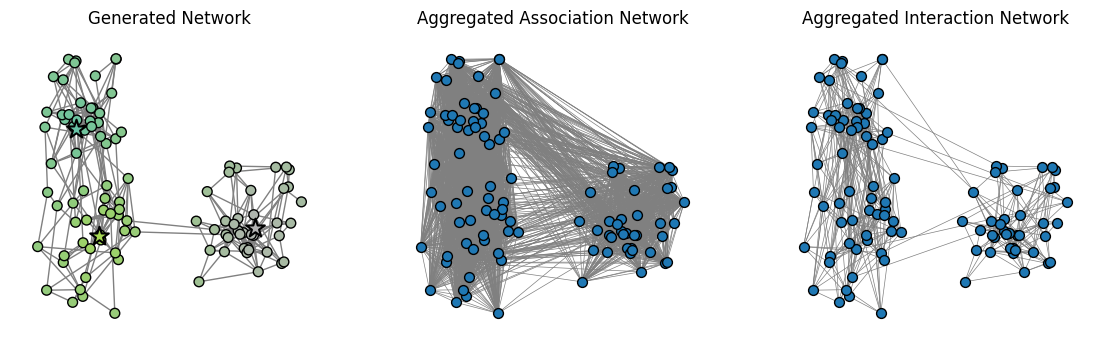

In [34]:
# Visualize
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.title("Generated Network")
plt.axis('off')
node_colors = color_nodes_by_centroid_distance(g, pos, centroids, "Set2")
nx.draw(g, pos=pos, node_size=50, edge_color='gray', edgecolors='black', node_color=node_colors)
centroid_colors = cm.Set2(np.linspace(0, 1, k))
for i, centroid in enumerate(centroids):
    plt.scatter(centroid[0], centroid[1], c=[centroid_colors[i]], s=200, 
                marker='*', edgecolors='black', linewidths=1.5, zorder=10)


plt.subplot(132)
plt.title("Aggregated Association Network")
nx.draw(
    aggregated_association_graph,
    pos,
    node_size=50,
    edge_color='gray',
    edgecolors='black',
    cmap='Set1',
    width=0.5
)

plt.subplot(133)
plt.title("Aggregated Interaction Network")
nx.draw(
    aggregated_interaction_graph,
    pos,
    node_size=50,
    edge_color='gray',
    edgecolors='black',
    cmap='Set2',
    width=0.5
)

This about wraps it up!


From there, the garden of forking path opens. One can run analyses of the aggregated graphs, interpret weights as probabilities, use reconstruction models, measure distributions of observables, etc.

## Appendix - Figure panels

Below, we implement our data-generating procedure to create the minimal example of our manuscript's Figure.
The main differences with the code above concern random seeds, parameter values, and the details of plotting functions.

We start by re-running the simulations:

In [88]:
# Random seed
rng_seed = 5
np.random.seed(rng_seed)
random.seed(rng_seed)

# Step 1: Generate a network with latent positions and connections based on distance
num_nodes = 20
k = 3
num_dims = 2
beta = 1.0
var_centroids = 8.0
var_positions = 0.5

g, centroids, pos = network_generation_model(
    num_nodes=num_nodes,
    k=k,
    centroid_generator=lambda: gaussian_centroids(num_dims, var_centroids),
    position_generator=lambda x: gaussian_position(x, var_positions),
    connection_function=lambda x, y: exponential_decay_connection(x, y, beta)
)

# Step 2: Generate groups based on the positions of the nodes
num_measurements = 12
noise = 0.4
labels = [group_formation_model(g, noise) for _ in range(num_measurements)]

# Step 3.1: Measure the association network from the groups
groups = [convert_labels_to_groups(l) for l in labels]
measurements = measure_association_network(groups)

# Step 3.2: Measure the interaction network from the groups
groups = [convert_labels_to_groups(l) for l in labels]
measurements = measure_interaction_network(groups, g)

# Step 4: Aggregate measurements
aggregated_interaction_graph = aggregate_measurements(measurements)

### Panel **A**: network of true ties

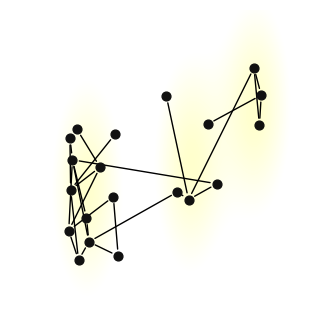

In [90]:
# Rescale positions to fit in a square [-1, 1] range
pos_array = np.array(list(pos.values()))
x_vals = 2 * (pos_array[:, 0] - np.min(pos_array[:, 0])) / (np.max(pos_array[:, 0]) - np.min(pos_array[:, 0])) - 1
y_vals = 2 * (pos_array[:, 1] - np.min(pos_array[:, 1])) / (np.max(pos_array[:, 1]) - np.min(pos_array[:, 1])) - 1
pos_rescaled = {node: (x_vals[i], y_vals[i]) for i, node in enumerate(pos)}

# Rescale centroids using same transformation
centroids_array = np.array(centroids)
c_x_vals = 2 * (centroids_array[:, 0] - np.min(pos_array[:, 0])) / (np.max(pos_array[:, 0]) - np.min(pos_array[:, 0])) - 1
c_y_vals = 2 * (centroids_array[:, 1] - np.min(pos_array[:, 1])) / (np.max(pos_array[:, 1]) - np.min(pos_array[:, 1])) - 1
centroids_rescaled = list(zip(c_x_vals, c_y_vals))

# Bounds and scaling for the Gaussian mixture
margin = 0.6
x_min, x_max = -1 - margin, 1 + margin
y_min, y_max = -1 - margin, 1 + margin

scale_x = (np.max(pos_array[:, 0]) - np.min(pos_array[:, 0])) / 2.0
scale_y = (np.max(pos_array[:, 1]) - np.min(pos_array[:, 1])) / 2.0
sigma_x = 1.0 / scale_x
sigma_y = 1.0 / scale_y

# Plot the network and Gaussian mixture heatmap
plt.figure(figsize=(4, 4))
nx.draw_networkx_nodes(g, pos_rescaled, node_size=40, node_color='#111', edgecolors='#111')
nx.draw_networkx_edges(g, pos_rescaled, node_size=40, min_source_margin=5, min_target_margin=5, arrows=True)

# Create Gaussian mixture surface
x = np.linspace(x_min, x_max, 250)
y = np.linspace(y_min, y_max, 250)
X, Y = np.meshgrid(x, y)

Z_mixture = np.zeros(X.shape)
for cx, cy in centroids_rescaled:
    Z = np.exp(-(((X - cx)**2) / (2 * sigma_x**2) + ((Y - cy)**2) / (2 * sigma_y**2)))
    Z_mixture += Z / len(centroids)

# Custom colormap
hot_cmap = plt.get_cmap('hot_r')
hot_cmap_colors = hot_cmap(np.linspace(0, 1, 256))
hot_cmap_white = np.vstack((np.array([1, 1, 1, 1]), hot_cmap_colors))
custom_hot_cmap = LinearSegmentedColormap.from_list('hot_cmap_white', hot_cmap_white)

# Plot the heatmap
plt.imshow(Z_mixture, extent=[x_min, x_max, y_min, y_max], origin='lower',
           vmin=0.1, vmax=1.5, cmap=custom_hot_cmap, alpha=0.3, interpolation='bilinear')

# Beautify
plt.axis('equal')
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.savefig('network.pdf', bbox_inches='tight')
plt.show()

### Panel **B**: day-to-day associations

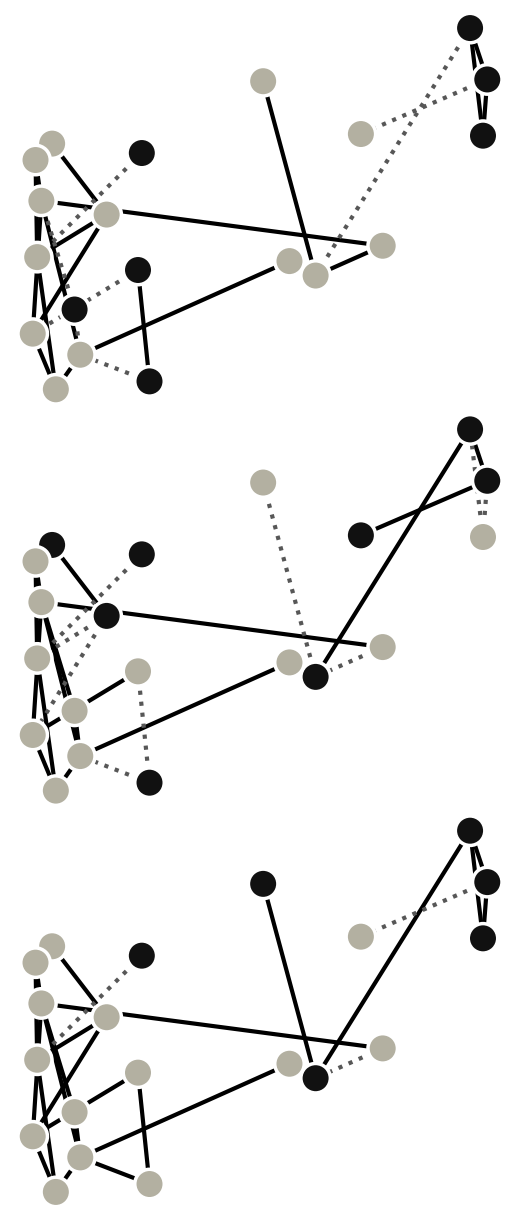

In [91]:
# Rescale positions
pos_array = np.array(list(pos.values()))
x_vals = 2 * (pos_array[:, 0] - np.min(pos_array[:, 0])) / (np.max(pos_array[:, 0]) - np.min(pos_array[:, 0])) - 1
y_vals = 2 * (pos_array[:, 1] - np.min(pos_array[:, 1])) / (np.max(pos_array[:, 1]) - np.min(pos_array[:, 1])) - 1
latent_pos = {node: (x_vals[i], y_vals[i]) for i, node in enumerate(pos)}

# Plot settings
fig = plt.figure(figsize=(5, 12))
gs = plt.GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0.01)

np.random.seed(42)
random.seed(42)
noise = [0.5, 0.5, 0.1]

for i in range(3):
    ax = plt.subplot(gs[i], frameon=False)
    ax.axis('off')
    ax.patch.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.margins(0, 0)

    groups = group_formation_model(g, noise[i])

    # Draw nodes by group
    nx.draw_networkx_nodes(
        g,
        latent_pos,
        node_size=450,
        node_color=['#b3b0a1' if c == 1 else '#111' for c in groups],
        edgecolors='white',
        linewidths=2.5
    )

    # Solid black edges: dyads that interact today
    nx.draw_networkx_edges(
        g,
        latent_pos,
        edgelist=[e for e in g.edges() if groups[e[0]] == groups[e[1]]],
        edge_color='#000000',
        width=3
    )

    # Dotted gray edges: dyads that have a tie but do not interact today
    nx.draw_networkx_edges(
        g,
        latent_pos,
        edgelist=[e for e in g.edges() if groups[e[0]] != groups[e[1]]],
        edge_color='#575757',
        style='dotted',
        width=3
    )

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
fig.canvas.draw_idle()

for ax in fig.get_axes():
    ax.set_axis_off()

plt.savefig('associations.pdf', bbox_inches='tight', pad_inches=0, transparent=True)

### Panel **C**: Measured networks and degree distribution

We start by sorting individual animals according to their position on the spectral layout:

In [94]:
def sort_nodes_by_spectral_layout(g):
    """
    Sort nodes based on their spectral layout for better visualization.

    Parameters
    ----------
    g : nx.Graph
        The network graph

    Returns
    -------
    list
        List of node indices sorted by spectral layout.
    """
    pos = nx.spectral_layout(g, dim=2)
    node_positions = [(node, pos[node][0], pos[node][1]) for node in g.nodes()]
    sorted_nodes = sorted(node_positions, key=lambda x: (x[1], x[2]))
    return [node[0] for node in sorted_nodes]    

We generate the heatmaps of panels **C4-C6**:

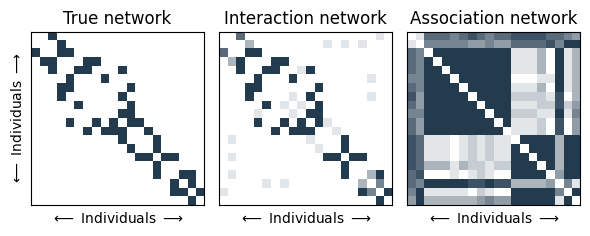

In [102]:
# Generate association network for comparison
groups = [convert_labels_to_groups(l) for l in labels]
association_measurements = measure_association_network(groups)
aggregated_association_graph = aggregate_measurements(association_measurements)

# Sort nodes using spectral layout from the true graph
sorted_nodes = sort_nodes_by_spectral_layout(g)

# Get adjacency matrices in the sorted order
A_true = nx.to_numpy_array(g, nodelist=sorted_nodes)
A_interaction = nx.to_numpy_array(aggregated_interaction_graph, nodelist=sorted_nodes)
A_association = nx.to_numpy_array(aggregated_association_graph, nodelist=sorted_nodes)

# Custom colormap: light gray (low values) to dark blue (high values)
custom_cmap = LinearSegmentedColormap.from_list('custom_gray', ['#FFFFFF', '#233b4f'])

# Plot the matrices
plt.figure(figsize=(6, 3))

plt.subplot(131)
plt.imshow(A_true, cmap=custom_cmap, vmin=0, vmax=1)
plt.xticks([])
plt.yticks([])
plt.xlabel(r'$\longleftarrow$ Individuals $\longrightarrow$')
plt.ylabel(r'$\longleftarrow$ Individuals $\longrightarrow$')
plt.title('True network')

plt.subplot(132)
plt.imshow(A_interaction, cmap=custom_cmap, vmin=0, vmax=8)
plt.xlabel(r'$\longleftarrow$ Individuals $\longrightarrow$')
plt.xticks([])
plt.yticks([])
plt.title('Interaction network')

plt.subplot(133)
plt.imshow(A_association, cmap=custom_cmap, vmin=0, vmax=8)
plt.xticks([])
plt.yticks([])
plt.xlabel(r'$\longleftarrow$ Individuals $\longrightarrow$')
plt.title('Association network')

plt.tight_layout()
plt.savefig('measurements.pdf', bbox_inches='tight')


We can now compute the average number of individuals having a certain degree (bars), and a 50% interval for this quantity (errorbars), with mean degree in inset.

In [103]:
def draw_degree_sequences(A, num_draws=10):
    P = A / A.max()  # normalize adjacency to probabilities
    degree_sequences = []
    for _ in range(num_draws):
        A_drawn = np.random.binomial(1, P, size=A.shape)
        k = np.sum(A_drawn, axis=0)  # degree per node
        degree_sequences.append(k)
    return np.array(degree_sequences)

def construct_mean_and_intervals(degree_sequences, interval=[25, 75]):
    """
    Construct mean and percentile intervals for degree counts.

    Returns:
        mean: mean counts per degree
        lb: lower percentile
        ub: upper percentile
        overall_mean: mean degree over all draws and nodes
    """
    max_k = degree_sequences.max()
    degrees = np.zeros((degree_sequences.shape[0], max_k + 1))
    for i, seq in enumerate(degree_sequences):
        counts = Counter(seq)
        for k, count in counts.items():
            degrees[i, k] = count
    mean = degrees.mean(axis=0)
    lb = np.percentile(degrees, interval[0], axis=0, method="interpolated_inverted_cdf")
    ub = np.percentile(degrees, interval[1], axis=0, method="interpolated_inverted_cdf")
    overall_mean = degree_sequences.mean()
    return mean, lb, ub, overall_mean

Barplot function:

In [104]:
def create_barplot(k, mean, lb, ub, width=0.1):
    plt.bar(k, mean, edgecolor='white', color='#6c808e', lw=0.7, alpha=0.9, width=width)
    for i, (m, lower, upper) in enumerate(zip(mean, lb, ub)):
        if m > 0:
            plt.plot([i, i], [lower, upper], lw=1, c="#243947")

Panels **C4-C6**:

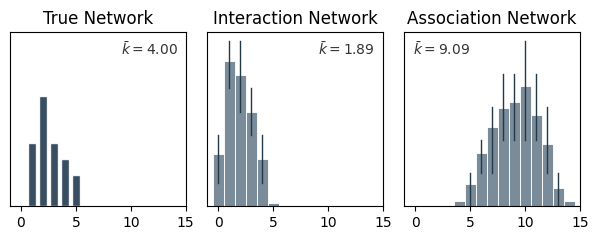

In [105]:
plt.figure(figsize=(6, 2.5))

# True network degree distribution
plt.subplot(131)
true_distribution = Counter([d for _, d in nx.degree(g)])
plt.bar(true_distribution.keys(), true_distribution.values(), edgecolor='white', color='#233b4f', lw=1, alpha=0.9)
plt.xlim(-1, 15)
plt.ylim(0, 11)
plt.yticks([])
overall_mean = np.mean(list(true_distribution.values()))
plt.text(0.63, 0.87, rf"$\bar{{k}}={overall_mean:.2f}$", color='#333', transform=plt.gca().transAxes)
plt.title("True Network")

# Interaction network degree distribution with intervals
plt.subplot(132)
degree_seq = draw_degree_sequences(A_interaction, num_draws=100)
mean, lb, ub, overall_mean = construct_mean_and_intervals(degree_seq)
create_barplot(range(len(mean)), mean, lb, ub, width=1)
plt.xlim(-1, 15)
plt.yticks([])
plt.text(0.63, 0.87, rf"$\bar{{k}}={overall_mean:.2f}$", color='#333', transform=plt.gca().transAxes)
plt.title("Interaction Network")

# Association network degree distribution with intervals
plt.subplot(133)
degree_seq = draw_degree_sequences(A_association, num_draws=100)
mean, lb, ub, overall_mean = construct_mean_and_intervals(degree_seq)
create_barplot(range(len(mean)), mean, lb, ub, width=1)
plt.xlim(-1, 15)
plt.yticks([])
plt.text(0.05, 0.87, rf"$\bar{{k}}={overall_mean:.2f}$", color='#333', transform=plt.gca().transAxes)
plt.title("Association Network")

plt.tight_layout()
plt.savefig('degree_distributions.pdf', bbox_inches='tight')
plt.show()